**Submission 3 Pengembangan Machine Learning**

Labib Ammar Fadhali
<br>labibfadhali12@gmail.com
<br><br>
Dataset : https://www.kaggle.com/datasets/alessiocorrado99/animals10


In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
upload=files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d alessiocorrado99/animals10

 98% 576M/586M [00:08<00:00, 75.0MB/s]
100% 586M/586M [00:08<00:00, 75.9MB/s]


In [5]:
!unzip '/content/animals10.zip' -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: /content/raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: /content/raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: /content/raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: /content/raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: /content/raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: /content/raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: /content/raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: /content/raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: /content/raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: /content/raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: /content/raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: /content/raw-img/ragno/OIP-MhRGx7d8nbnHBuqrsO00E

In [33]:
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet152V2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

%matplotlib inline

In [34]:
base_dir='/content/raw-img'
os.listdir(base_dir)

['gallina',
 'elefante',
 'cavallo',
 'mucca',
 'scoiattolo',
 'gatto',
 'cane',
 'pecora',
 'ragno',
 'farfalla']

In [35]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [36]:
img_size=(224,224)
batch_size=32

train_generator=datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator=datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [37]:
base_model=ResNet152V2(include_top=False, weights="imagenet",input_shape=(224,224,3))
base_model.summary()

234545216/234545216 [==============================] - 1s 0us/step
Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                     

In [38]:
for layer in base_model.layers:
    layer.trainable = False

In [39]:
model=Sequential([
    base_model,
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 5, 32)          589856    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 2, 2, 32)          0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 2, 2, 32)          0         
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               66048     
                                                      

In [41]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [42]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs.get('accuracy')>0.93) and (logs.get('val_accuracy')>0.93):
      print('\n accuracy and val_accuracy > 93%')
      self.model.stop_training=True
callbacks=myCallback()

In [43]:
history=model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[callbacks]
)

Epoch 1/50
654/654 [==============================] - 403s 599ms/step - loss: 0.7564 - accuracy: 0.7962 - val_loss: 0.3996 - val_accuracy: 0.9043
Epoch 2/50
654/654 [==============================] - 395s 604ms/step - loss: 0.5565 - accuracy: 0.8537 - val_loss: 0.3553 - val_accuracy: 0.8974
Epoch 3/50
654/654 [==============================] - 383s 586ms/step - loss: 0.4873 - accuracy: 0.8736 - val_loss: 0.3033 - val_accuracy: 0.9183
Epoch 4/50
654/654 [==============================] - 396s 605ms/step - loss: 0.4303 - accuracy: 0.8858 - val_loss: 0.2789 - val_accuracy: 0.9285
Epoch 5/50
654/654 [==============================] - 392s 600ms/step - loss: 0.4345 - accuracy: 0.8858 - val_loss: 0.2890 - val_accuracy: 0.9245
Epoch 6/50
654/654 [==============================] - 386s 591ms/step - loss: 0.3756 - accuracy: 0.9003 - val_loss: 0.2488 - val_accuracy: 0.9327
Epoch 7/50
654/654 [==============================] - 394s 602ms/step - loss: 0.3711 - accuracy: 0.9017 - val_loss: 0.2450 -

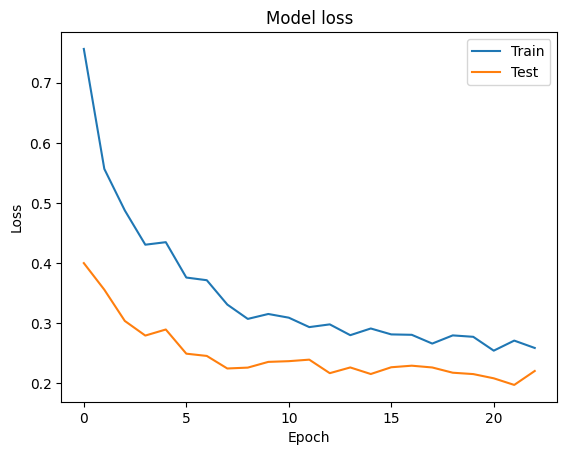

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

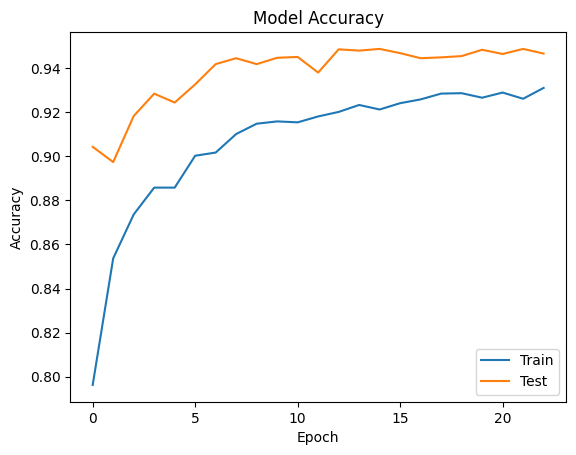

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

In [46]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [47]:
model_name = 'model.tflite'

with open(model_name, 'wb') as f:
    f.write(tflite_model)

print(f"Model telah disimpan dalam format TF-Lite dengan nama file: {model_name}")

Model telah disimpan dalam format TF-Lite dengan nama file: model.tflite
